# Problem Statement

An investment company is looking to collate a list of posts on reddit for investment-related trends, which they can recommend the type of investment to a client or user based on their comments. Noting that the comments are mostly from retail investors discussing between stocks and cryptocurrency, they want to classify these comments accordingly. The company has commissioned you to build a classification model based off subreddits specifically from r/CryptoCurrency and r/stocks, to help train and build the model to classify these comments to the correct topic. This would allow the the company to suggest the correct type of investments a client should make based on their comments.

- Scrape sample comments off subreddits r/CryptoCurrency and r/stocks
- Provide possible trend analysis based on scraped data
- To build a classification model that can classify the subreddits with minimal misclassifications 

# Data Import and Cleaning

## Import Libraries and datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score,plot_roc_curve, roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from wordcloud import WordCloud

In [2]:
crypto_df = pd.read_csv('../data/cryptocurrency.csv')
stocks_df = pd.read_csv('../data/stocks.csv')

main_df = pd.concat([crypto_df,stocks_df])[['subreddit','selftext','title','author']]
main_df.reset_index(inplace=True)
main_df.drop(labels='index', inplace=True, axis=1)

## Initialise helper methods for data cleaning and confusion matrix plotting

In [3]:
def clean_data(data):
    url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)(;\w+.?\w+)?'
    num_regex = r'\d+'
    word_regex = r"(\w+'*\w+)"#r'[A-Za-z]+'
    non_word_regex = r'\b(amp|ha|wa|thi|xb)\b|[&;â€œ™,.]'
    x = re.sub(url_regex,'',data)
    x = re.sub(num_regex,'',x)
    word_tokenizer = RegexpTokenizer(word_regex)
    x = word_tokenizer.tokenize(x.lower())
    tmp_lst = [re.sub(non_word_regex,'',i) for i in x]
    return ' '.join(tmp_lst)

In [4]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f_one_score = f1_score(y, preds)
    roc_auc = roc_auc_score(y, classifier.predict_proba(X)[:,1])
    results = {
        'accuracy': acc,
        'misclassification_rate': misclass,
        'sensitivity': sens,
        'specificity': spec,
        'precision': prec,
        'f1_score':f_one_score,
        'roc_auc':roc_auc
    }
    cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d',display_labels=['CryptoCurrency (1)','Stocks (0)']);
    metrics = pd.DataFrame({
        'metric': results.keys(),
        'score': results.values(),
        'cm': cm_chart
        })
    return metrics

In [5]:
def append_results(result, train_score, metric, classifier, vec, misclass_data):
    tmp = pd.DataFrame({
        'model':classifier,
        'vectorizer':vec,
        'train_accuracy': train_score,
        'test_accuracy': metric[metric['metric'] == 'accuracy']['score'].values[0],
        'misclassification': metric[metric['metric'] == 'misclassification_rate']['score'].values[0],
        'sensitivity': metric[metric['metric'] == 'sensitivity']['score'].values[0],
        'specificity': metric[metric['metric'] == 'specificity']['score'].values[0],
        'precision': metric[metric['metric'] == 'precision']['score'].values[0],
        'f1_score': metric[metric['metric'] == 'f1_score']['score'].values[0],
        'roc_auc':metric[metric['metric'] == 'roc_auc']['score'].values[0],
        'chart': metric['cm'],
        'misclassed_data':misclass_data
    }, index=[0])
    result = pd.concat([result,tmp], axis=0, ignore_index=True)
    return result

In [6]:
def compare_cvec_tvec(df, stopwords='english'):
    cvec = CountVectorizer(stop_words=stopwords, ngram_range=(1,3))
    tvec = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3))
    cvec_sc = cvec.fit_transform(df)
    cvec_df = pd.DataFrame(cvec_sc.todense(), columns=cvec.get_feature_names())
    tvec_sc = tvec.fit_transform(df)
    tvec_df = pd.DataFrame(tvec_sc.todense(), columns=tvec.get_feature_names())
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,15))
    cvec_df.sum().sort_values(ascending=False).head(25).plot(kind='barh', ax=ax[0][0])
    tvec_df.sum().sort_values(ascending=False).head(25).plot(kind='barh', ax=ax[0][1])
    ax[0][0].set_title('Count Vectorizer Word Count', fontweight='bold')
    ax[0][0].set_xlabel('Count')
    ax[0][0].set_ylabel('Word')
    ax[0][1].set_title('TFIDF Vectorizer Word Count', fontweight='bold')
    ax[0][1].set_xlabel('Count')
    ax[0][1].set_ylabel('Word')
    
    cvec_wc = WordCloud(background_color="white", max_words=150, colormap='cividis').generate_from_frequencies(cvec_df.sum().sort_values(ascending=False).T)
    tvec_wc = WordCloud(background_color="white", max_words=150, colormap='cividis').generate_from_frequencies(tvec_df.sum().sort_values(ascending=False).T)
    ax[1][0].axis('off')
    ax[1][0].imshow(cvec_wc)
    ax[1][1].axis('off')
    ax[1][1].imshow(tvec_wc)

    
    

In [7]:
def lemma_text(col):
    lemmatizer = WordNetLemmatizer()
    text_token = word_tokenize(col)
    lemma_text = [lemmatizer.lemmatize(tok) for tok in text_token]
    return ' '.join(lemma_text)

In [8]:
def stem_text(col):
    p_stemmer = PorterStemmer()
    text_token = word_tokenize(col)
    stem_text = [p_stemmer.stem(tok) for tok in text_token]
    return ' '.join(stem_text)

In [9]:
def compare_cm(df, model_type):
    left, right = df.loc[df['model'] == model_type]['chart']
    fig, axs = plt.subplots(1,2,figsize=(12,5))

    left.plot(ax=axs[0], cmap='Blues')
    plt.suptitle(model_type, fontsize=20)
    axs[0].title.set_text('With CountVectorizer')
    right.plot(ax=axs[1], cmap='Blues')
    axs[1].title.set_text('With TfidfVectorizer')
    plt.tight_layout()

In [10]:
def get_misclassed_data(test_data,predicted, actual):
    df = pd.DataFrame({
        'predicted':predicted,
        'actual':actual
    })
    idx = df[df['predicted'] != df['actual']].index
    tmp_lst = [i for i in test_data[idx]]
    return [tmp_lst]


In [11]:
def plot_best_features(df, model, vectorizer):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    left_one = df.sort_values(ascending=False, by='coefficient').head(10)
    right_zero = df.sort_values(ascending=False, by='coefficient').tail(10)
    
    plt.suptitle(t=f'{model} using {vectorizer}',
                fontsize='20',
                weight='3')
    
    sns.barplot(data=left_one, y='word', x='coefficient', ax=ax[0])
    ax[0].title.set_text('Cryptocurrency')
    sns.barplot(data=right_zero, y='word', x='coefficient', ax=ax[1])
    ax[1].title.set_text('Stocks')

In [12]:
def plot_compare_roc_auc(cvec_classifier, tvec_classifier, X, y):
   
    fig, ax = plt.subplots(figsize=(8,8))
    plot_roc_curve(cvec_classifier, X, y, ax=ax)
    plot_roc_curve(tvec_classifier, X, y, ax=ax)
    ax.plot([0, 1], [0, 1], label='baseline', linestyle='--', )

In [195]:
def plot_compare_diff_cm(left, right, left_title, right_title, title):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    left.plot(ax=ax[0], cmap='Blues')
    plt.suptitle(title, fontsize=20)
    ax[0].title.set_text(left_title)
    right.plot(ax=ax[1], cmap='Blues')
    ax[1].title.set_text(right_title)
    plt.tight_layout()

## Data Cleaning and Mapping

I do a basic check here to ensure we don't have any empty or null data within our combined dataset.

In [14]:
main_df.isnull().sum()

subreddit    0
selftext     0
title        0
author       0
dtype: int64

In [15]:
main_df.head()

,subreddit,selftext,title,author
0,CryptoCurrency,"I'm pretty new to crypto, just got in this yea...","Not Your Keys, Not Your Coin",Agonze
1,CryptoCurrency,Coinbase will not be launching its crypto lend...,The SEC bullied coinbase into dropping their 4...,Acceptable-Sort-8429
2,CryptoCurrency,I strongly believe Ryan Reynolds and Rob McElh...,Wrexham Football Club as a DAO,theblockofblocks
3,CryptoCurrency,You will want to take your ALGOs off any excha...,"ALGO hodlers, don't forget governance starts O...",ag11600
4,CryptoCurrency,"If you're bringing up mobile phones, smart dev...",Blockchain's relevance- The link between milit...,the_far_yard


In [16]:
main_df.tail()

,subreddit,selftext,title,author
2025,stocks,Hi all -- I'm hoping for help understanding wh...,Help requested: What is my 401(k) invested in?,bizzle6
2026,stocks,Obviously tobacco consumption has declined con...,Looking to get into weed/vape/tobacco companie...,BiscuitsNbacon
2027,stocks,Hey guys. I have been using free tools until n...,What tools/services are worth paying for?,jacklychi
2028,stocks,What happens to stocks when the company goes b...,Can hedge funds or retail still own stock in a...,VideoGameDelivery
2029,stocks,I have 40k in my Charles Schwab account. My I...,Another annoying question about what I should ...,mercifulhawk


### Merge selftext and title as a combined feature to use as X

Here, I merge our `selftext` and `title` columns into 1 feature, which we will use mainly for X. I also created 2 additional features for comparative purposes between lemmatization and stemming later.

In [17]:
main_df['selftext_title'] = main_df['selftext'] + main_df['title']

In [18]:
main_df['selftext_title'] = main_df['selftext_title'].apply(clean_data)

In [19]:
main_df['lemma_selftext_title'] = main_df['selftext_title'].apply(lemma_text)

In [20]:
main_df['stem_selftext_title'] = main_df['selftext_title'].apply(stem_text)

Afterwhich, our subreddits are mapped accordingly to 1 (CryptoCurrency) and 0 (stocks).

In [21]:
main_df['subreddit'] = main_df['subreddit'].map({'CryptoCurrency':1, 'stocks':0})


### Stopwords

Here, I use the base package of stopwords from the english language in the CountVectorizer library. This will allow us to exclude basic common terms which are uninformative in representing the context and content of the subreddit.

Additionally, to prevent overfitting the model with very easily classifiable words to the subreddit, I added and combined our own list of stopwords, which will be used across our models. I also add some stopwords here to reduce noise.

In [202]:
eng_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())
self_def_stopwords = ['cryptocurrency','crypto','stocks','stock','shares','bitcoin','ethereum','coin','blockchain','coins','trading','cryptocurrencies','tokens','cryptos','know','time','buy','just','like','people','money','don','ve','good','price','going','think','market','new','year','want','term','said','looking','years','long','years','help','gt','company','companies','sell','dip','tell','uses','day','make','use','right','way','does','lot','say','need','really','today','lot','week','big','days','cash','bought','month','ll','post','high','best','look','using','love','free','mind','ago','asked','words','opens']
list_of_stopwords = eng_stopwords + self_def_stopwords

# Exploratory Data Analysis

## Posts by AutoModerator bots

Subreddits usually have `AutoModerator` bots to post reminders or guidelines to the subreddit on a daily/weekly basis. These posts tend to be repetitive and are not unique in their content. Looking at the % count for posts from this author, it only constitutes less than 2% of our dataset. We can drop these rows.

In [23]:
main_df.loc[:, 'author'].value_counts(normalize=True)

AutoModerator         0.014778
psychotrader00        0.006404
UltimateTraders       0.006404
coolcomfort123        0.003941
Wiardv                0.003941
                        ...   
johngaltspeaking      0.000493
WhiteHoney88          0.000493
No_Mushroom7353       0.000493
truestorybro123321    0.000493
SAFUMaster            0.000493
Name: author, Length: 1587, dtype: float64

In [24]:
main_df.drop(main_df[main_df['author'] == 'AutoModerator'].index,inplace=True)

## Consideration of Lemmatizer and Stemmer for Pre-Processing

Earlier, I created additional features just to see and compare between the lemmatizer and stemmer, on which stemming method is more ideal in identifying words. I also use a CountVectorizer and TFIDFVectorizer to compare how the transformers work against each stemming method when counting the occurence of words.

Words from using the WordNetLemmatizer looks more complete, as it bases the words against a large lexical database of English. However, we also notice a high frequency of oddly reduced words like `ha` and `wa`, which could be representative of exclamations in laughter or surprise.

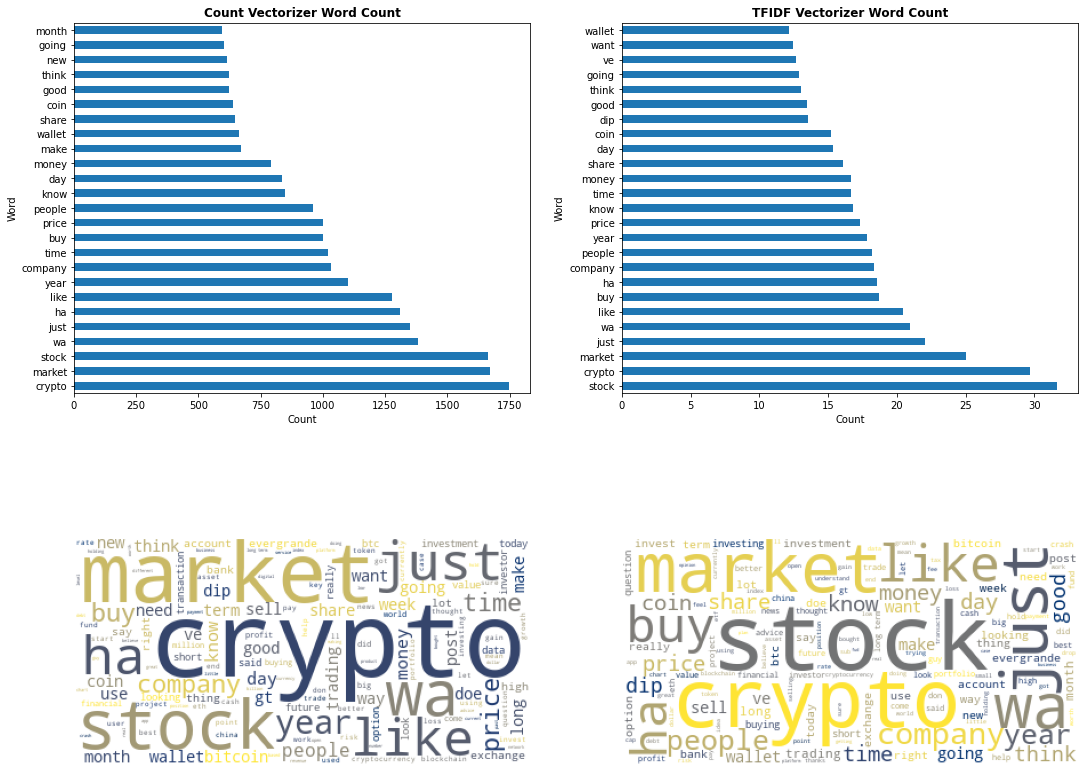

In [25]:
compare_cvec_tvec(main_df['lemma_selftext_title'])

On applying stemming, I also notice that the words after stemming don't necessarily reduce well. We notice words like `ani`, `whi` or `compani`, which might not carry any contextual meaning as it has been accidentally stemmed to its base root form due to the effects of the stemmer.

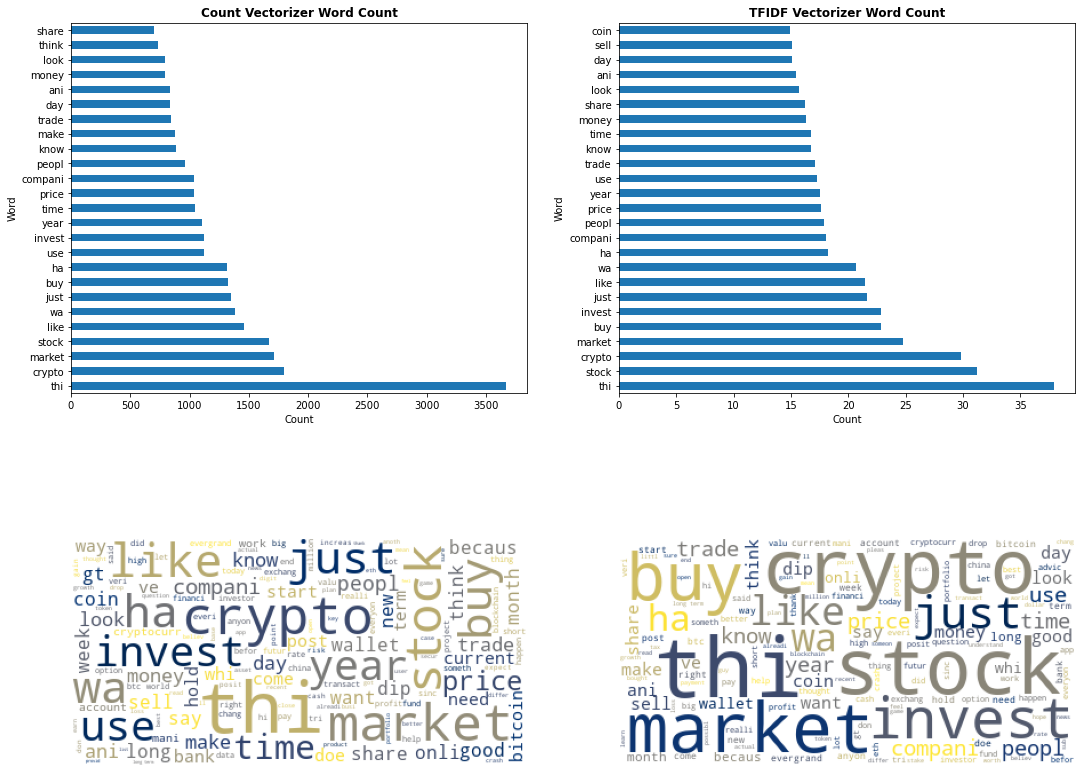

In [26]:
compare_cvec_tvec(main_df['stem_selftext_title'])

The original cleansed data without any lemmatizing or stemming does provide words that are more insightful, as shown by both CountVectorizer and TfidfVectorizer below.

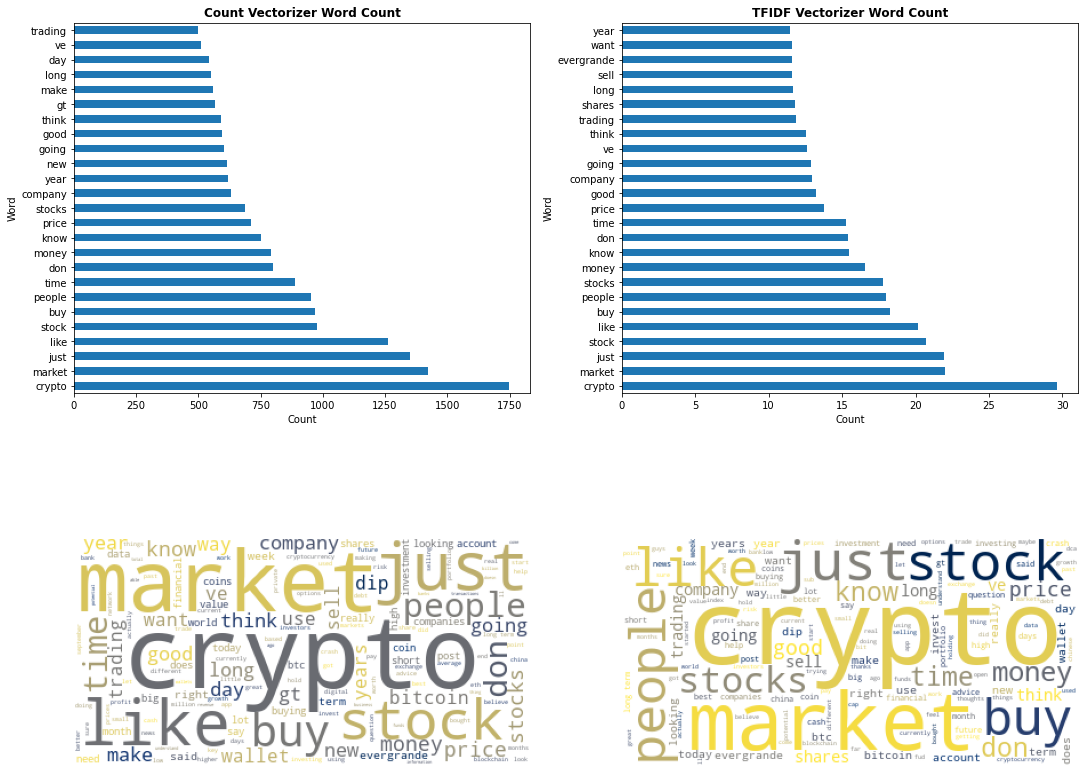

In [27]:
compare_cvec_tvec(main_df['selftext_title'])

Therefore in view of the results, I won't be using any lemmatizing or stemming here.

## Comparison of top 25 word counts between CountVectorizer and TfidfVectorizer

From the charts below in comparison with our stopwords, we can see that CountVectorizer, which tends to only count the highest frequency of words, picks out words that are commonly used within our subreddits.

TfidfVectorizer on the other hand, is able to pick up much more relatable words to the subreddit topics instead. This is because TfidfVectorizer scores words based on the number of times it appears in the corpus, dimishing the weight of words that occur too frequently.

In [28]:
crypto_df['selftext_title'] = crypto_df['selftext'] + crypto_df['title']
crypto_df['selftext_title'] = crypto_df['selftext_title'].apply(clean_data)

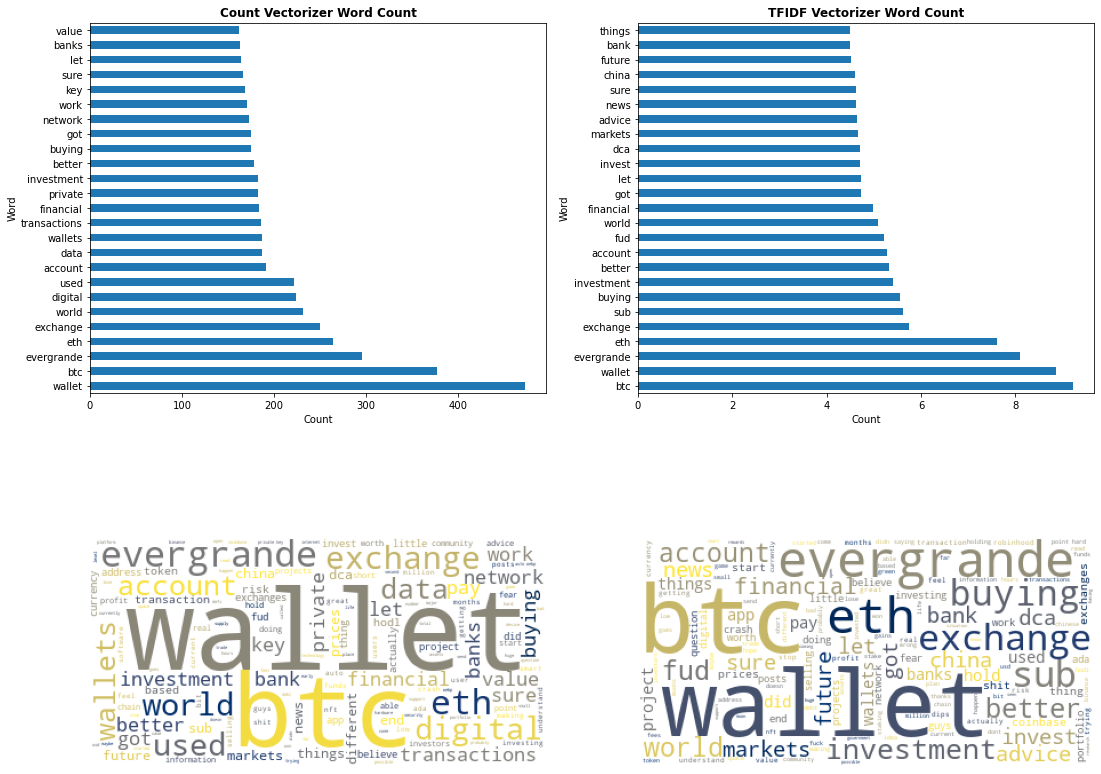

In [29]:
compare_cvec_tvec(crypto_df['selftext_title'], list_of_stopwords)

As a sanity check, I do a sample run of the CryptoCurrency data to see the count of words, and also to see if there are any similar tokens in the text as compared to our stocks data. The idea is to try and include any indicative text that might aid to the classification of one subreddit over the other.

In [30]:
stocks_df['selftext_title'] = stocks_df['selftext'] + stocks_df['title']
stocks_df['selftext_title'] = stocks_df['selftext_title'].apply(clean_data)

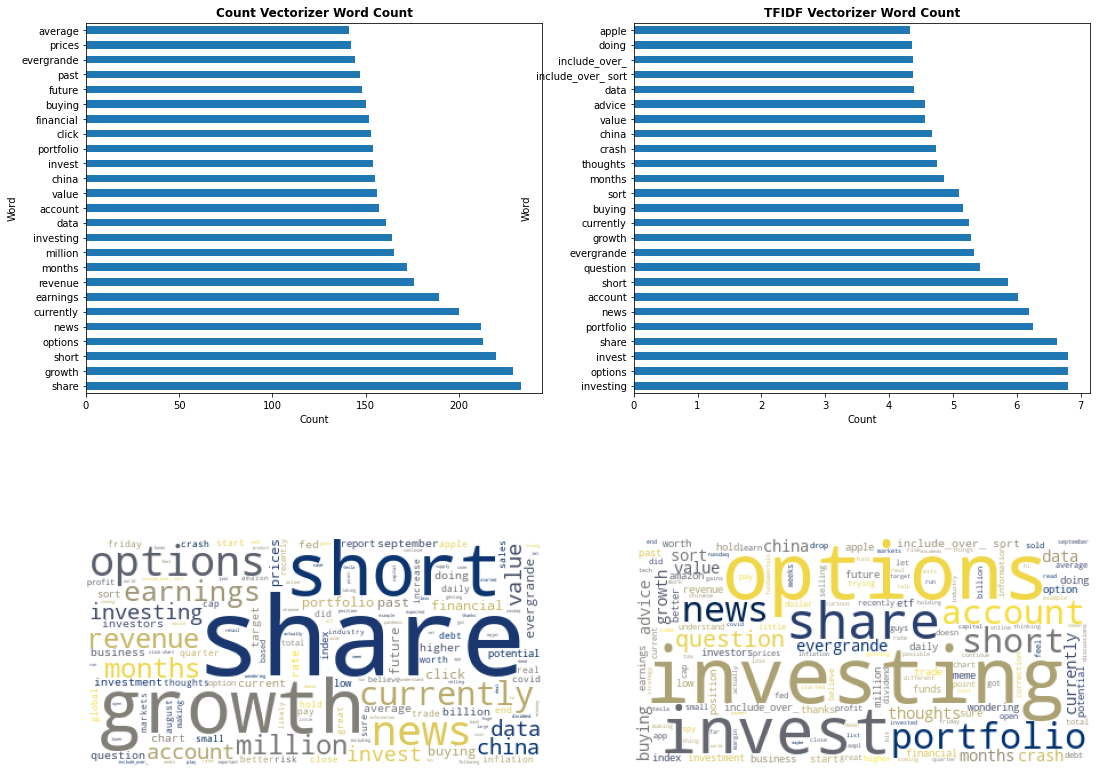

In [31]:
compare_cvec_tvec(stocks_df['selftext_title'], list_of_stopwords)

Similarly, we do the same here in our stocks dataframe. Note that we see the term `evergrande` appearing in both subreddits. This is likely due to the recent news on the Chinese real-estate developer Evergrande going on default due to debt<sup>1</sup>, particularly in housing. This is likely due to investors pulling out, and similarly recouping losses<sup>2</sup> via cryptocurrency, which saw a surge recently.

We also see `china` as one of the top 30 words highlighted in our TfidfVectorizer. This is likely also due to the recent crackdown in which cryptocurrency is treated as illegal<sup>3</sup> and is banned in China. `exchange` also appears as keywords as cryptocurrency exchanges are now scrambling to sever business ties with mainland Chinese clients<sup>4</sup>.

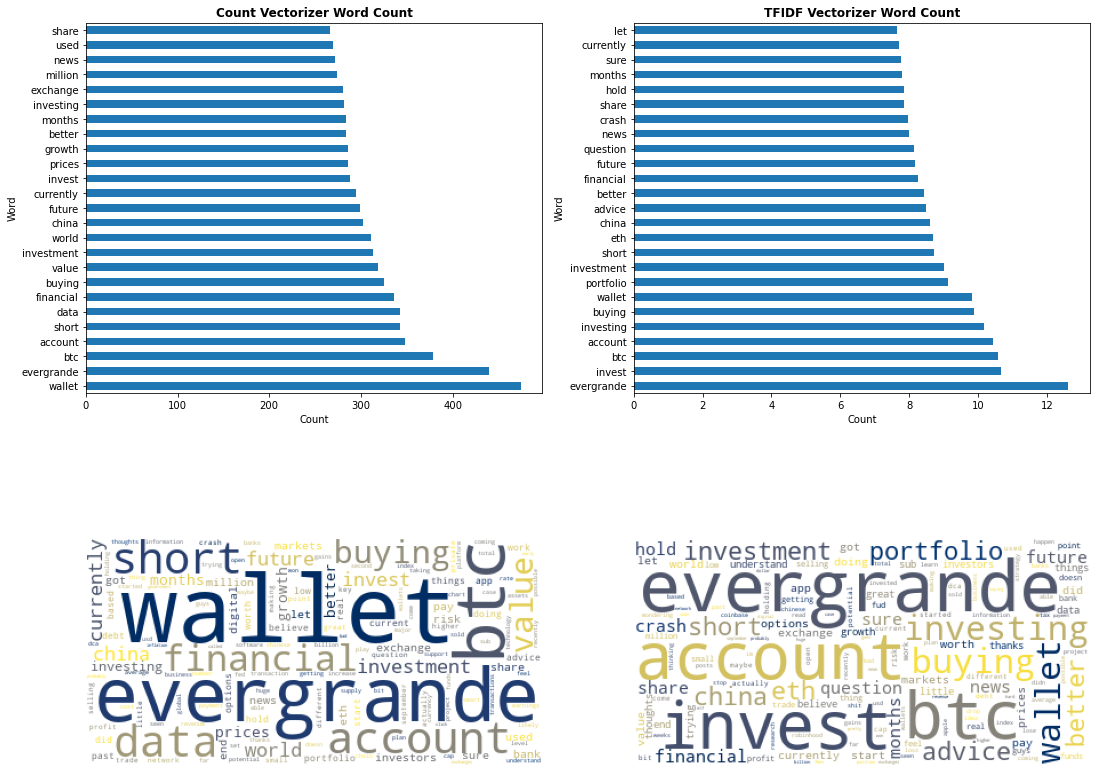

In [32]:
compare_cvec_tvec(main_df['selftext_title'],list_of_stopwords)

Finally, I visually compare the results of the text count from the combined subreddits via both CountVectorizer and TfidfVectorizer. Because CountVectorizer only counts the frequency of words, words with rarer occurences won't appear at the top. This might result the loss of predictive power as some rare words might carry better meaning on classifying in the correct subreddit.

Comparatively, we see that words such as `portfolio` and `crash` being picked up as the top 30 in the TfidfVectorizer instead. This could mean that some words with high importance might not have been recognised with a high score count in our CountVectorizer instead.

As we run our models below later, we can see that in some models, CountVectorizer tends to aid our models poorly than TfidfVectorizer for feature engineering.

<a id='model'></a>
# Modelling

I run a series of modelling with GridSearch, both using CountVectorizer and TfidfVectorizer to compare between both vectorizers, and also to compare various performances across different models.

- [Logistic Regression](#logreg)
- [k-Nearest Neighbors](#knn)
- [Naive Bayes](#nb)
- [Decision Trees](#tree)
- [Bagging](#bag)
- [Random Forest](#rf)
- [ExtraTrees](#et)

**Note**: *Models have already been pre-tuned with best hyperparameters during development to reduce re-run computation time*

I also create `results_df` to store and record each model's metrics for evaluation later.

In [33]:
results_df = pd.DataFrame(columns=['model',
                                   'vectorizer',
                                   'train_accuracy',
                                   'test_accuracy',
                                   'misclassification',
                                   'sensitivity',
                                   'specificity',
                                   'precision',
                                   'f1_score',
                                   'roc_auc',
                                   'chart',
                                   'misclassed_data'])

## Train, Test and Split

In [34]:
X = main_df['selftext_title']
y = main_df['subreddit']

In [35]:
y.value_counts(normalize=True)

1    0.5055
0    0.4945
Name: subreddit, dtype: float64

Although the data is split almost equally, stratify ensure that when we split our train and test dataset, there is an equal distribution of records from both subreddits. I also set our baseline accuracy score to be 50%.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

<a id='logreg'></a>
## Logistic Regression 

### CountVectorizer with Logistic Regression

In [37]:
pipe_cvec_logreg = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('logreg',LogisticRegression(random_state=42)),
])

In [38]:
# pipe_logreg_params = {
#     'cvec__max_features': [None,2000,3000,4000,5000],
#     'cvec__min_df': [2,3],
#     'cvec__max_df': [.85,.9,.95],
#     'cvec__ngram_range': [(1,1),(1,2),(1,3)],
# }


pipe_cvec_logreg_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1,1),(1,2)],
}

In [39]:
gs_cvec_logreg = GridSearchCV(pipe_cvec_logreg, param_grid=pipe_cvec_logreg_params, cv=5)

In [40]:
gs_cvec_logreg.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [41]:
gs_cvec_logreg.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2)}

In [42]:
print(f'Best score for training: {gs_cvec_logreg.best_score_}')
print(f'Accuracy on train set: {gs_cvec_logreg.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_cvec_logreg.score(X_test, y_test)}')

Best score for training: 0.8800000000000001
Accuracy on train set: 0.995625
Accuracy on test set: 0.85


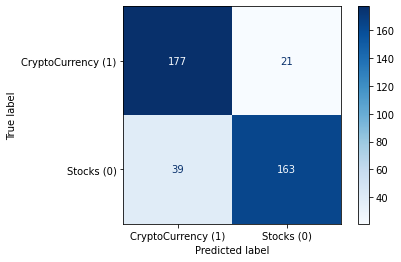

In [43]:
mod_metrics = metrics_and_plot_cm(gs_cvec_logreg,X_test, y_test)

In [44]:
results_df = append_results(results_df,
                            gs_cvec_logreg.score(X_train,y_train),
                            mod_metrics,
                            'Logistic Regression',
                            'CountVectorizer',
                            get_misclassed_data(X_test, gs_cvec_logreg.predict(X_test), y_test)
                           )

In [45]:
top_cvec_logreg_features = pd.DataFrame(gs_cvec_logreg.best_estimator_['logreg'].coef_, 
                                   columns=gs_cvec_logreg.best_estimator_['cvec'].get_feature_names())
top_cvec_logreg_features = top_cvec_logreg_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

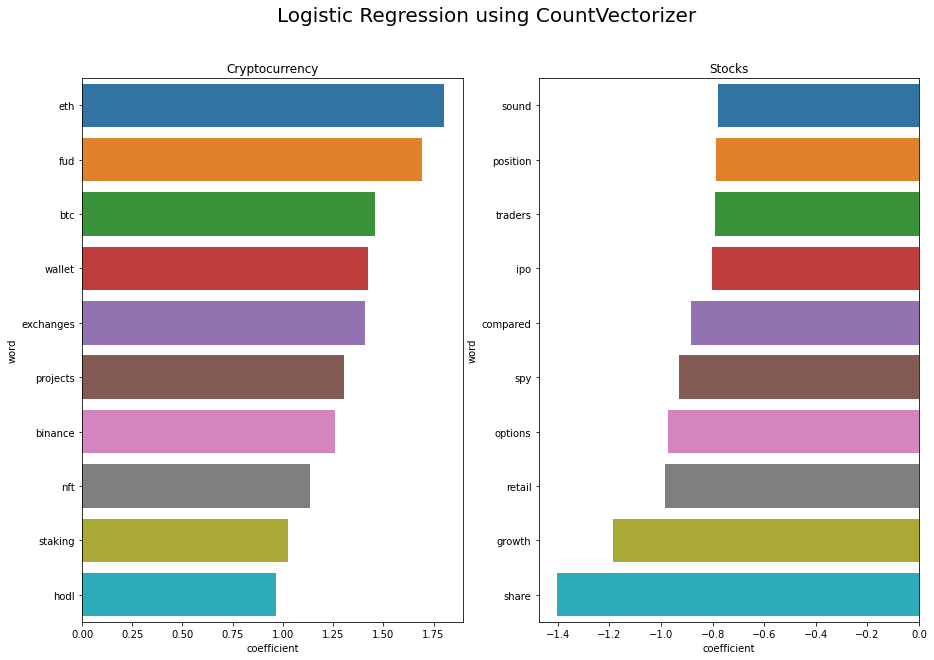

In [46]:
plot_best_features(top_cvec_logreg_features,'Logistic Regression','CountVectorizer')

### TfidfVectorizer with Logistic Regression

In [47]:
pipe_tvec_logreg = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('logreg',LogisticRegression(random_state=42)),
])

In [48]:
# pipe_logreg_tvec_params = {
#     'tvec__max_features': [None,2000,3000,4000,5000],
#     'tvec__min_df': [2,3],
#     'tvec__max_df': [.85,.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
# }

pipe_tvec_logreg_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.85],
    'tvec__ngram_range': [(1,1),(1,2)],
}

In [49]:
gs_tvec_logreg = GridSearchCV(pipe_tvec_logreg, param_grid=pipe_tvec_logreg_params, cv=5)

In [50]:
%%time
gs_tvec_logreg.fit(X_train,y_train)

Wall time: 2.56 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [51]:
gs_tvec_logreg.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [52]:
print(f'Best score for training: {gs_tvec_logreg.best_score_}')
print(f'Accuracy on train set: {gs_tvec_logreg.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_tvec_logreg.score(X_test, y_test)}')

Best score for training: 0.890625
Accuracy on train set: 0.969375
Accuracy on test set: 0.8825


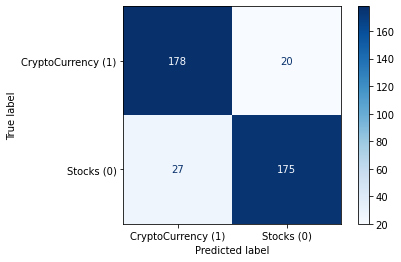

In [53]:
mod_metrics = metrics_and_plot_cm(gs_tvec_logreg,X_test, y_test)

In [54]:
results_df = append_results(results_df,
                            gs_tvec_logreg.score(X_train,y_train),
                            mod_metrics,
                            'Logistic Regression',
                            'TfidfVectorizer',
                            get_misclassed_data(X_test, gs_tvec_logreg.predict(X_test), y_test)
                           )

In [55]:
top_tvec_logreg_features = pd.DataFrame(gs_tvec_logreg.best_estimator_['logreg'].coef_, 
                                   columns=gs_tvec_logreg.best_estimator_['tvec'].get_feature_names())
top_tvec_logreg_features = top_tvec_logreg_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

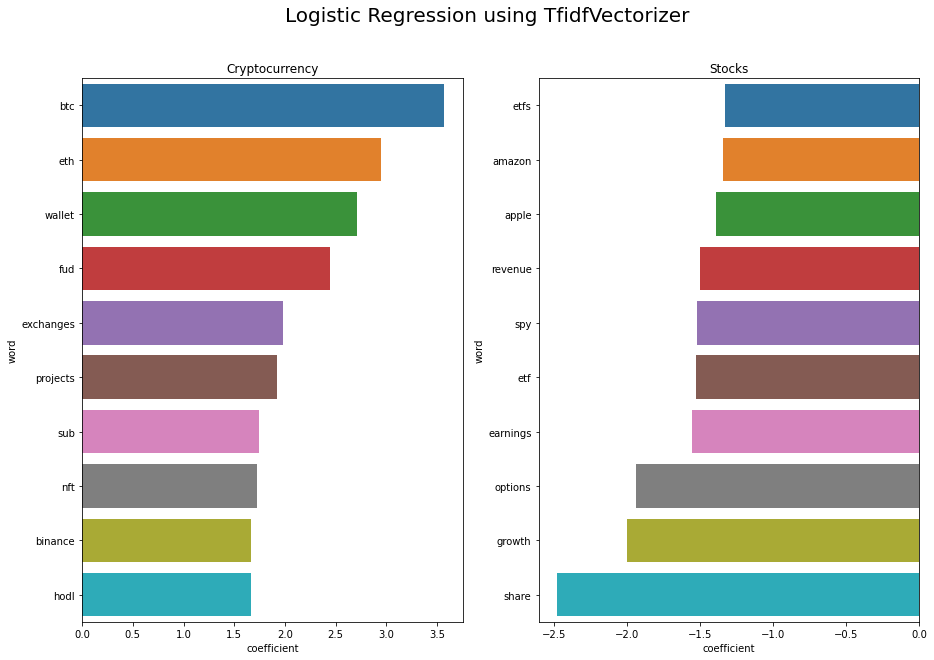

In [56]:
plot_best_features(top_tvec_logreg_features,'Logistic Regression','TfidfVectorizer')

### Comparing both Logistic Regression Models

In [57]:
results_df.loc[results_df['model'] == 'Logistic Regression',['vectorizer','train_accuracy','test_accuracy','misclassification','sensitivity','specificity','precision','f1_score','roc_auc']]

,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,CountVectorizer,0.995625,0.8500,0.1500,0.806931,0.893939,0.885870,0.844560,0.934343
1,TfidfVectorizer,0.969375,0.8825,0.1175,0.866337,0.898990,0.897436,0.881612,0.953570


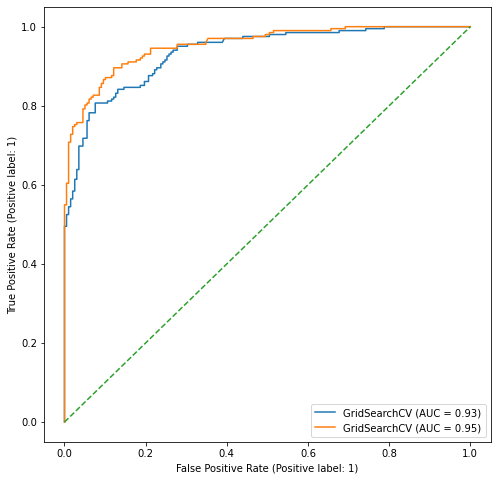

In [58]:
plot_compare_roc_auc(gs_cvec_logreg, gs_tvec_logreg, X_test, y_test)

**Key Observations**
- Train accuracy drops slightly when using TfidfVectorizer, but Test Accuracy slightly improves.
- Metrics when using TfidfVectorizer is better
- Logistic Regression model classifies quite for both vectorizers
- Clear segregation of words to related topics for both vectorizers

<hr style="border:2px solid gray"> </hr>

<a id='knn'></a>
## k-Nearest Neighbors

### CountVectorizer with k-NN Classifier

In [59]:
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('knn',KNeighborsClassifier()),
])

In [60]:
# pipe_cvec_knn_params = {
#     'cvec__max_features': [None,2000,3000,4000,5000],
#     'cvec__min_df': [2,3],
#     'cvec__max_df': [.85],
#     'cvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'knn__n_neighbors': [5,6,7,8,9,10],

# }

pipe_cvec_knn_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1,2)],
    'knn__n_neighbors': [13],

}



In [61]:
gs_cvec_knn = GridSearchCV(pipe_cvec_knn, param_grid=pipe_cvec_knn_params, cv=5, verbose=1)

In [62]:
%%time
gs_cvec_knn.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [63]:
gs_cvec_knn.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2),
 'knn__n_neighbors': 13}

In [64]:
print(f'Best score for training: {gs_cvec_knn.best_score_}')
print(f'Accuracy on train set: {gs_cvec_knn.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_cvec_knn.score(X_test, y_test)}')


Best score for training: 0.553125
Accuracy on train set: 0.5825
Accuracy on test set: 0.5625


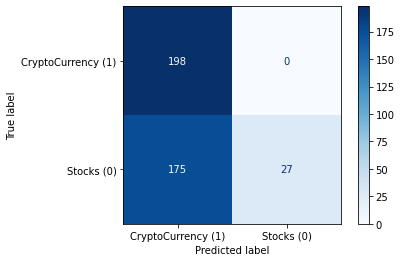

In [65]:
mod_metrics = metrics_and_plot_cm(gs_cvec_knn,X_test, y_test)

In [66]:
results_df = append_results(results_df,
                            gs_cvec_knn.score(X_train,y_train),
                            mod_metrics,
                            'K-Nearest Neighbors',
                            'CountVectorizer',
                            get_misclassed_data(X_test, gs_cvec_knn.predict(X_test), y_test)
                           )

### TfidfVectorizer with k-NN Classifier

In [67]:
pipe_tvec_knn = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('knn',KNeighborsClassifier()),
])

In [68]:
pipe_tvec_knn_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1),(1,2)],
    'knn__n_neighbors': [13],

}

In [69]:
gs_tvec_knn = GridSearchCV(pipe_tvec_knn, param_grid=pipe_tvec_knn_params, cv=5, verbose=1)

In [70]:
%%time
gs_tvec_knn.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 2.61 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [71]:
gs_tvec_knn.best_params_

{'knn__n_neighbors': 13,
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [72]:
print(f'Best score for training: {gs_tvec_knn.best_score_}')
print(f'Accuracy on train set: {gs_tvec_knn.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_tvec_knn.score(X_test, y_test)}')

Best score for training: 0.8331250000000001
Accuracy on train set: 0.876875
Accuracy on test set: 0.835


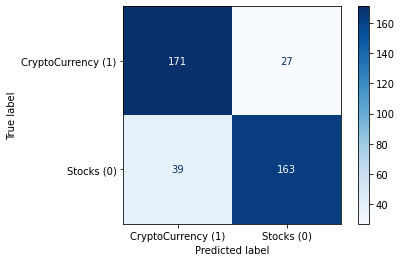

In [73]:
mod_metrics = metrics_and_plot_cm(gs_tvec_knn,X_test, y_test)

In [74]:
results_df = append_results(results_df,
                            gs_tvec_knn.score(X_train,y_train),
                            mod_metrics,
                            'K-Nearest Neighbors',
                            'TfidfVectorizer',
                            get_misclassed_data(X_test, gs_tvec_knn.predict(X_test), y_test)
                           )

### Comparing both k-NN Models

In [75]:
results_df.loc[results_df['model'] == 'K-Nearest Neighbors',['vectorizer','train_accuracy','test_accuracy','misclassification','sensitivity','specificity','precision','f1_score','roc_auc']]

,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
2,CountVectorizer,0.582500,0.5625,0.4375,0.133663,1.000000,1.000000,0.235808,0.726273
3,TfidfVectorizer,0.876875,0.8350,0.1650,0.806931,0.863636,0.857895,0.831633,0.905366


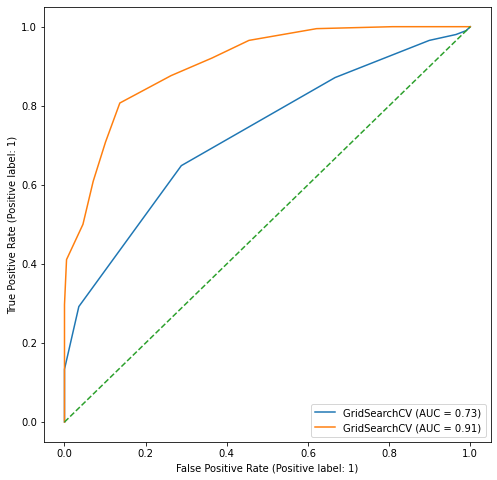

In [76]:
plot_compare_roc_auc(gs_cvec_knn, gs_tvec_knn, X_test, y_test)

**Key Observations**
- Very low training and test accuracy score when using CountVectorizer, but better performance in terms of accuracy when using TfidfVectorizer. F1 score for k-NN with CountVectorizer is quite bad, which 
- Possible low score due to K-Nearest Neighbor being a better classifier for distance-based metrics
- CountVectorized k-NN model has worst performing score, possibly due to count of rounds not a relatable and contributing factor with nearest words as an estimate.

<hr style="border:2px solid gray"> </hr>

<a id='nb'></a>
## Naive Bayes

### CountVectorizer with Naive Bayes

In [77]:
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('nb', MultinomialNB())
])

In [78]:
pipe_cvec_nb_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)],
    'nb__alpha':[0.25]
}

In [79]:
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, param_grid=pipe_cvec_nb_params, cv=5, verbose=1)

In [80]:
%%time
gs_cvec_nb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.69 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [81]:
gs_cvec_nb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.25}

In [82]:
print(f'Best score for training: {gs_cvec_nb.best_score_}')
print(f'Accuracy on train set: {gs_cvec_nb.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_cvec_nb.score(X_test, y_test)}')

Best score for training: 0.878125
Accuracy on train set: 0.92
Accuracy on test set: 0.87


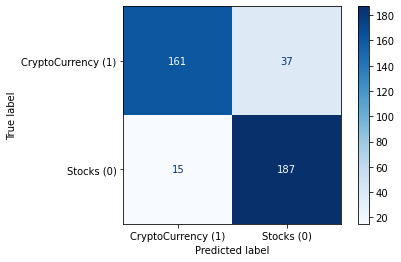

In [83]:
mod_metrics = metrics_and_plot_cm(gs_cvec_nb,X_test, y_test)

In [84]:
results_df = append_results(results_df,
                            gs_cvec_nb.score(X_train,y_train),
                            mod_metrics,
                            'Naive Bayes',
                            'CountVectorizer',
                            get_misclassed_data(X_test, gs_cvec_nb.predict(X_test), y_test)
                           )

In [85]:
cvec_nb_log_prob_diff = gs_cvec_nb.best_estimator_['nb'].feature_log_prob_[1] - gs_cvec_nb.best_estimator_['nb'].feature_log_prob_[0] 

In [86]:
top_cvec_nb_features = pd.DataFrame([cvec_nb_log_prob_diff], 
                                   columns=gs_cvec_nb.best_estimator_['cvec'].get_feature_names())
top_cvec_nb_features = top_cvec_nb_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

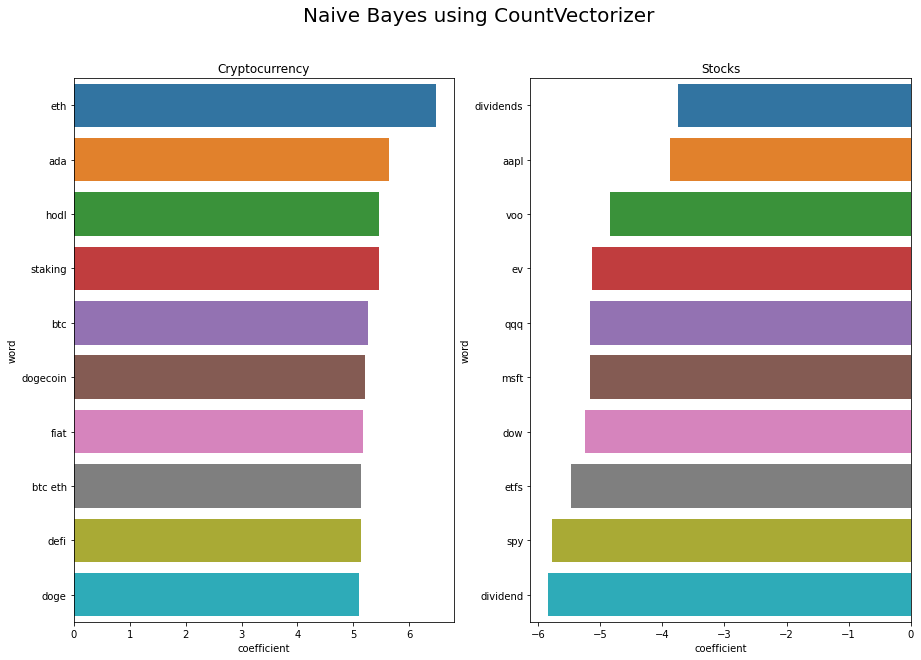

In [87]:
plot_best_features(top_cvec_nb_features,'Naive Bayes','CountVectorizer')

### TfidfVectorizer with Naive Bayes Classifier

In [88]:
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('nb', MultinomialNB())
])

In [89]:
# pipe_tvec_nb_params = {
#     'tvec__max_features': [None,2000,3000,4000],
#     'tvec__min_df': [.2],
#     'tvec__max_df': [.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'nb__alpha':[0.1,1,10]
# }

pipe_tvec_nb_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1),(1,2)],
    'nb__alpha':[0.1]
}


In [90]:
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, param_grid=pipe_tvec_nb_params, cv=5, verbose=1)

In [91]:
%%time
gs_tvec_nb.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 2.44 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [92]:
gs_tvec_nb.best_params_

{'nb__alpha': 0.1,
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [93]:
print(f'Best score for training: {gs_tvec_nb.best_score_}')
print(f'Accuracy on train set: {gs_tvec_nb.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_tvec_nb.score(X_test, y_test)}')

Best score for training: 0.8925000000000001
Accuracy on train set: 0.938125
Accuracy on test set: 0.89


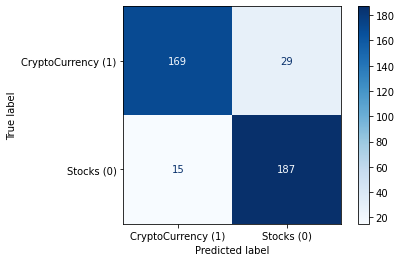

In [94]:
mod_metrics = metrics_and_plot_cm(gs_tvec_nb,X_test, y_test)

In [95]:
results_df = append_results(results_df,
                            gs_tvec_nb.score(X_train,y_train),
                            mod_metrics,
                            'Naive Bayes',
                            'TfidfVectorizer',
                            get_misclassed_data(X_test, gs_tvec_nb.predict(X_test), y_test)
                           )

In [96]:
tvec_nb_log_prob_diff = gs_tvec_nb.best_estimator_['nb'].feature_log_prob_[1] - gs_tvec_nb.best_estimator_['nb'].feature_log_prob_[0] 
top_tvec_nb_features = pd.DataFrame([tvec_nb_log_prob_diff], 
                                   columns=gs_tvec_nb.best_estimator_['tvec'].get_feature_names())
top_tvec_nb_features = top_tvec_nb_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

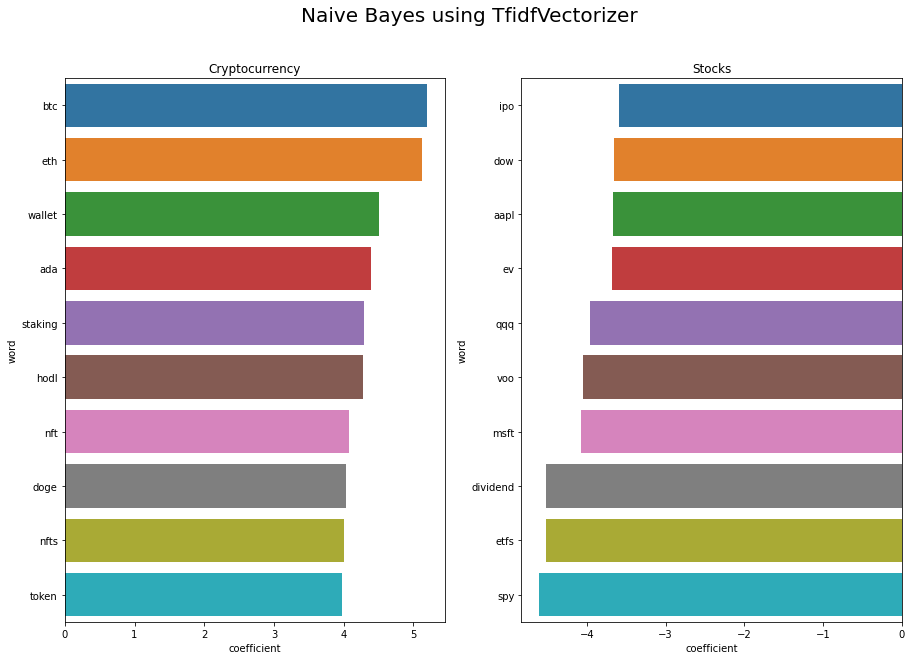

In [97]:
plot_best_features(top_tvec_nb_features,'Naive Bayes','TfidfVectorizer')

### Comparing both Naive Bayes Models

In [98]:
results_df.loc[results_df['model'] == 'Naive Bayes',['vectorizer','train_accuracy','test_accuracy','misclassification','sensitivity','specificity','precision','f1_score','roc_auc']]

,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
4,CountVectorizer,0.920000,0.87,0.13,0.925743,0.813131,0.834821,0.877934,0.957996
5,TfidfVectorizer,0.938125,0.89,0.11,0.925743,0.853535,0.865741,0.894737,0.960671


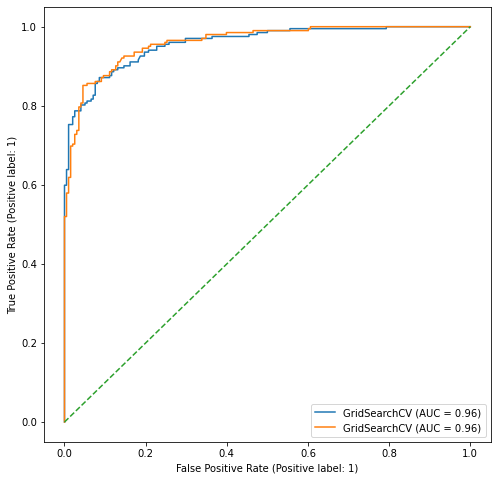

In [99]:
plot_compare_roc_auc(gs_cvec_nb,gs_tvec_nb, X_test, y_test)

**Key Observations**
- Similar metric scores to Logistic Regression models
- Test accuracy better than Logistic Regression models
- Higher ROC AUC scores compared to Logistic Regression models

<hr style="border:2px solid gray"> </hr>

<a id='tree'></a>
## Decision Tree Classifier

### CountVectorizer with DecisionTreeClassifier

In [100]:
pipe_cvec_tree = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('tree', DecisionTreeClassifier(random_state=42))
])

In [101]:
pipe_cvec_tree_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,1),(1,2)],
    'tree__min_samples_split': [10],
    'tree__min_samples_leaf': [15],
    'tree__ccp_alpha': [0.001],
    'tree__max_depth':[None],
}

In [102]:
gs_cvec_tree = GridSearchCV(estimator=pipe_cvec_tree, 
                            param_grid=pipe_cvec_tree_params,
                            cv=5,
                            verbose=1,
                            n_jobs=-1)

In [103]:
%%time
gs_cvec_tree.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 2.52 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [104]:
gs_cvec_tree.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'tree__ccp_alpha': 0.001,
 'tree__max_depth': None,
 'tree__min_samples_leaf': 15,
 'tree__min_samples_split': 10}

In [105]:
print(f'Best score for training: {gs_cvec_tree.best_score_}')
print(f'Accuracy on train set: {gs_cvec_tree.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_cvec_tree.score(X_test, y_test)}')

Best score for training: 0.778125
Accuracy on train set: 0.844375
Accuracy on test set: 0.7775


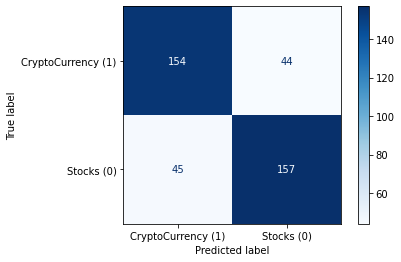

In [106]:
mod_metrics = metrics_and_plot_cm(gs_cvec_tree,X_test, y_test)

In [107]:
results_df = append_results(results_df,
                            gs_cvec_tree.score(X_train,y_train),
                            mod_metrics,
                            'Decision Tree',
                            'CountVectorizer',
                            get_misclassed_data(X_test, gs_cvec_tree.predict(X_test), y_test)
                           )

In [108]:
top_cvec_tree_features = pd.DataFrame([gs_cvec_tree.best_estimator_['tree'].feature_importances_], 
                                   columns=gs_cvec_tree.best_estimator_['cvec'].get_feature_names())
top_cvec_tree_features = top_cvec_tree_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

### TfidfVectorizer with DecisionTreeClassifier

In [109]:
pipe_tvec_tree = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('tree', DecisionTreeClassifier(random_state=42))
])

In [110]:
# pipe_tree_params = {
#     'tvec__max_features': [None],
#     'tvec__min_df': [.2,.3],
#     'tvec__max_df': [.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2)],
#     'tree__max_depth': [None],
#     'tree__min_samples_split': [5,10,15,20],
#     'tree__min_samples_leaf': [2,3,4,5,6],
#     'tree__ccp_alpha': [0,0.001,0.01,0.1,1,10]
# }

pipe_tvec_tree_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.9,],
    'tvec__ngram_range': [(1,2)],
    'tree__max_depth': [20],
    'tree__min_samples_split': [10],
    'tree__min_samples_leaf': [5],
     'tree__ccp_alpha': [0.001]
}

In [111]:
gs_tvec_tree = GridSearchCV(estimator = pipe_tvec_tree,
                      param_grid=pipe_tvec_tree_params,
                      cv=5,
                      verbose=1,
                      n_jobs=-1
                     )

In [112]:
%%time
gs_tvec_tree.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.87 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [113]:
gs_tvec_tree.best_params_

{'tree__ccp_alpha': 0.001,
 'tree__max_depth': 20,
 'tree__min_samples_leaf': 5,
 'tree__min_samples_split': 10,
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [114]:
print(f'Best score for training: {gs_tvec_tree.best_score_}')
print(f'Accuracy on train set: {gs_tvec_tree.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_tvec_tree.score(X_test, y_test)}')

Best score for training: 0.7925000000000001
Accuracy on train set: 0.851875
Accuracy on test set: 0.8075


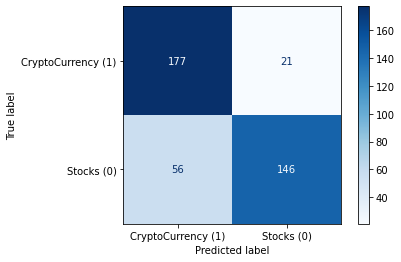

In [115]:
mod_metrics = metrics_and_plot_cm(gs_tvec_tree,X_test, y_test)

In [116]:
results_df = append_results(results_df,
                            gs_tvec_tree.score(X_train,y_train),
                            mod_metrics,
                            'Decision Tree',
                            'TfidfVectorizer',
                            get_misclassed_data(X_test, gs_tvec_tree.predict(X_test), y_test)
                           )

In [117]:
top_tvec_tree_features = pd.DataFrame([gs_tvec_tree.best_estimator_['tree'].feature_importances_], 
                                   columns=gs_tvec_tree.best_estimator_['tvec'].get_feature_names())
top_tvec_tree_features = top_tvec_tree_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

### Comparing both Decision Tree Models

In [118]:
results_df.loc[results_df['model'] == 'Decision Tree',['vectorizer','train_accuracy','test_accuracy','misclassification','sensitivity','specificity','precision','f1_score','roc_auc']]

,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
6,CountVectorizer,0.844375,0.7775,0.2225,0.777228,0.777778,0.781095,0.779156,0.860274
7,TfidfVectorizer,0.851875,0.8075,0.1925,0.722772,0.893939,0.874251,0.791328,0.843784


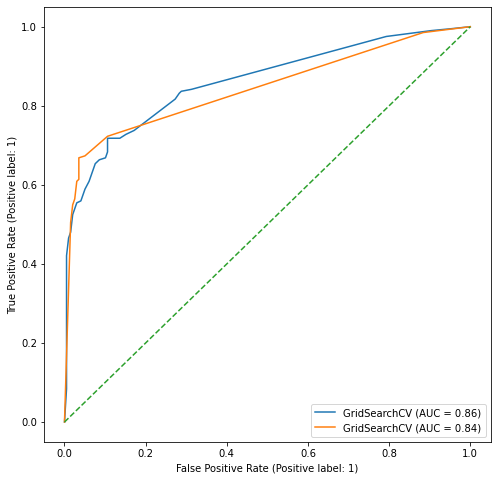

In [119]:
plot_compare_roc_auc(gs_cvec_tree, gs_tvec_tree, X_test, y_test)

**Key Observations**
- Not very good accuracy with Decision Trees, as compared to other models.
- Generally good classification, performing way better than the baseline

<hr style="border:2px solid gray"> </hr>

<a id='bag'></a>
## Bagging with DecisionTreeClassifier

### CountVectorizer with Bagging

In [120]:
pipe_cvec_bag = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),bootstrap=True))
])

In [121]:
# Best params found
pipe_cvec_bag_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1,1)],
    'bag__n_estimators': [150],
}

In [122]:
gs_cvec_bag = GridSearchCV(estimator = pipe_cvec_bag,
                      param_grid=pipe_cvec_bag_params,
                      cv=5,
                      verbose=1,
                      n_jobs=-1
                     )

In [123]:
%%time
gs_cvec_bag.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 17.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [124]:
gs_cvec_bag.best_params_

{'bag__n_estimators': 150,
 'cvec__max_df': 0.85,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1)}

In [125]:
print(f'Best score for training: {gs_cvec_bag.best_score_}')
print(f'Accuracy on train set: {gs_cvec_bag.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_cvec_bag.score(X_test, y_test)}')

Best score for training: 0.8606250000000001
Accuracy on train set: 1.0
Accuracy on test set: 0.84


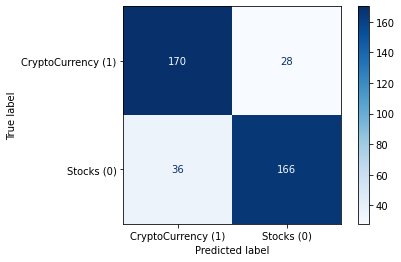

In [126]:
mod_metrics = metrics_and_plot_cm(gs_cvec_bag,X_test, y_test)

In [127]:
results_df = append_results(results_df,
                            gs_cvec_bag.score(X_train,y_train),
                            mod_metrics,
                            'Bagging',
                            'CountVectorizer',
                            get_misclassed_data(X_test, gs_cvec_bag.predict(X_test), y_test)
                           )

In [128]:
top_cvec_bag_features = pd.DataFrame([np.mean([tree.feature_importances_ for tree in gs_cvec_bag.best_estimator_['bag']],axis=0)], 
                                     columns=gs_cvec_bag.best_estimator_['cvec'].get_feature_names())
top_cvec_bag_features = top_cvec_bag_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

In [129]:
top_cvec_bag_features.sort_values(ascending=False, by='coefficient').head(10)

,word,coefficient
140,btc,0.089093
1319,wallet,0.054968
482,fud,0.042462
393,eth,0.033428
405,exchanges,0.028514
935,projects,0.026355
570,hodl,0.023666
904,posts,0.016241
1238,token,0.015539
805,nft,0.015113


### TfidfVectorizer with Bagging

In [130]:
pipe_tvec_bag = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),bootstrap=True))
])

In [131]:
# pipe_bag_params = {
#     'tvec__max_features': [None,2000,3000,4000,5000],
#     'tvec__min_df': [.2,.3],
#     'tvec__max_df': [.85,.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'bag__n_estimators': [10,20,30],
# }

# Best params found
pipe_tvec_bag_params = {
    'tvec__max_features': [None],
     'tvec__min_df': [.01],
     'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2)],
    'bag__n_estimators': [150],
}

In [132]:
gs_tvec_bag = GridSearchCV(estimator = pipe_tvec_bag,
                      param_grid=pipe_tvec_bag_params,
                      cv=5,
                      n_jobs=-1
#                       verbose=1
                     )

In [133]:
%%time
gs_tvec_bag.fit(X_train, y_train)

Wall time: 37.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [134]:
gs_tvec_bag.best_params_

{'bag__n_estimators': 150,
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 1)}

In [135]:
print(f'Best score for training: {gs_tvec_bag.best_score_}')
print(f'Accuracy on train set: {gs_tvec_bag.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_tvec_bag.score(X_test, y_test)}')

Best score for training: 0.859375
Accuracy on train set: 1.0
Accuracy on test set: 0.86


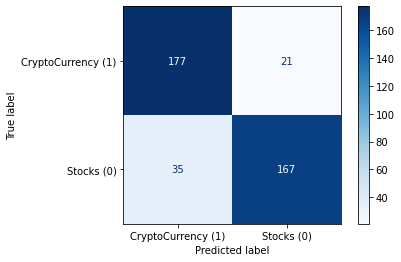

In [136]:
mod_metrics = metrics_and_plot_cm(gs_tvec_bag,X_test, y_test)

In [137]:
results_df = append_results(results_df,
                            gs_tvec_bag.score(X_train,y_train),
                            mod_metrics,
                            'Bagging',
                            'TfidfVectorizer',
                            get_misclassed_data(X_test, gs_tvec_bag.predict(X_test), y_test)
                           )

### Comparing both Bagging Models

In [138]:
top_tvec_bag_features = pd.DataFrame([np.mean([tree.feature_importances_ for tree in gs_tvec_bag.best_estimator_['bag']],axis=0)], 
                                     columns=gs_tvec_bag.best_estimator_['tvec'].get_feature_names())
top_tvec_bag_features = top_tvec_bag_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

In [139]:
results_df.loc[results_df['model'] == 'Bagging',['vectorizer','train_accuracy','test_accuracy','misclassification','sensitivity','specificity','precision','f1_score','roc_auc']]

,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
8,CountVectorizer,1.0,0.84,0.16,0.821782,0.858586,0.855670,0.838384,0.916642
9,TfidfVectorizer,1.0,0.86,0.14,0.826733,0.893939,0.888298,0.856410,0.917667


In [140]:
top_tvec_bag_features.sort_values(ascending=False, by='coefficient').head(10)

,word,coefficient
140,btc,0.095532
1319,wallet,0.059163
482,fud,0.043874
405,exchanges,0.032013
935,projects,0.029850
393,eth,0.028079
570,hodl,0.021665
1186,sub,0.019376
1257,transactions,0.017560
904,posts,0.017306


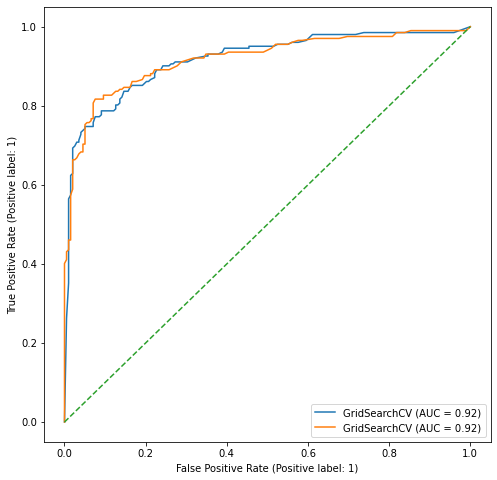

In [141]:
plot_compare_roc_auc(gs_cvec_bag, gs_tvec_bag, X_test, y_test)

**Key Observations**
- Performs well on average within the 80-90% accuracy range.
- ROC AUC score is very good, showing that the model is able to distinguish between our classifications very well.

<hr style="border:2px solid gray"> </hr>

<a id='rf'></a>
## Random Forest Classifier

### CountVectorizer with RandomForest Classifier

In [142]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('rf', RandomForestClassifier(random_state=42)),
])

In [143]:
pipe_cvec_rf_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,2)],
    'rf__n_estimators':[100],
    'rf__min_samples_leaf':[3],
    'rf__max_depth':[7],
    #'rf__min_samples_split':[5],
    #'rf__ccp_alpha':[0.1]
}

In [144]:
gs_cvec_rf = GridSearchCV(estimator=pipe_cvec_rf,
                     param_grid=pipe_cvec_rf_params,
                     cv=5,
                          n_jobs=-1
#                      verbose=1
                    )

In [145]:
%%time
gs_cvec_rf.fit(X_train, y_train)

Wall time: 859 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [146]:
gs_cvec_rf.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2),
 'rf__max_depth': 7,
 'rf__min_samples_leaf': 3,
 'rf__n_estimators': 100}

In [147]:
print(f'Best score for training: {gs_cvec_rf.best_score_}')
print(f'Accuracy on train set: {gs_cvec_rf.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_cvec_rf.score(X_test, y_test)}')

Best score for training: 0.86
Accuracy on train set: 0.888125
Accuracy on test set: 0.8525


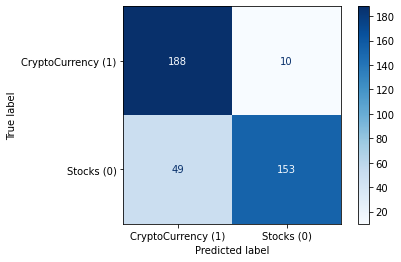

In [148]:
mod_metrics = metrics_and_plot_cm(gs_cvec_rf,X_test, y_test)

In [149]:
results_df = append_results(results_df,
                            gs_cvec_rf.score(X_train,y_train),
                            mod_metrics,
                            'Random Forest',
                            'CountVectorizer',
                            get_misclassed_data(X_test, gs_cvec_rf.predict(X_test), y_test)
                           )

In [150]:
top_cvec_rf_features = pd.DataFrame([gs_cvec_rf.best_estimator_['rf'].feature_importances_], 
                                   columns=gs_cvec_rf.best_estimator_['cvec'].get_feature_names())
top_cvec_rf_features = top_cvec_rf_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

In [151]:
top_cvec_rf_features.sort_values(ascending=False, by='coefficient').head(10)

,word,coefficient
142,btc,0.068956
402,eth,0.045596
1347,wallet,0.041257
416,exchanges,0.036647
586,hodl,0.027975
496,fud,0.025569
19,ada,0.025432
27,adoption,0.023601
954,projects,0.021479
542,growth,0.018974


### TfidfVectorizer with Random Forest Classifier

In [152]:
pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('rf', RandomForestClassifier(random_state=42)),
])

In [153]:
# pipe_rf_params = {
#     'tvec__max_features': [None,2000,3000],
#     'tvec__min_df': [.2,.3],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'rf__n_estimators':[100,150,200],
#     'rf__max_depth': [None, 1, 2, 3],
# }

# Best params for Random Forest
pipe_tvec_rf_params = {
    'tvec__max_features': [None,3000,4000],
    'tvec__min_df': [.01],
#     'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,2)],
    'rf__n_estimators':[100,150,200],
    'rf__min_samples_leaf':[3,5,7],
    'rf__max_depth':[7,8,9],
}

In [154]:
gs_tvec_rf = GridSearchCV(estimator=pipe_tvec_rf,
                     param_grid=pipe_tvec_rf_params,
                     cv=5,
                          n_jobs=-1
#                      verbose=1
                    )

In [155]:
%%time
gs_tvec_rf.fit(X_train, y_train)

Wall time: 27.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [156]:
gs_tvec_rf.best_params_

{'rf__max_depth': 9,
 'rf__min_samples_leaf': 3,
 'rf__n_estimators': 100,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [157]:
print(f'Best score for training: {gs_tvec_rf.best_score_}')
print(f'Accuracy on train set: {gs_tvec_rf.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_tvec_rf.score(X_test, y_test)}')

Best score for training: 0.8674999999999999
Accuracy on train set: 0.905625
Accuracy on test set: 0.86


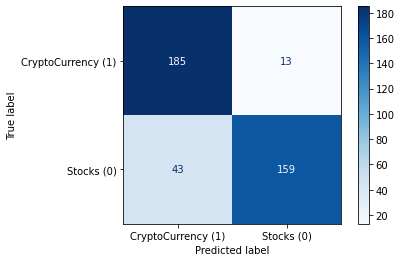

In [158]:
mod_metrics = metrics_and_plot_cm(gs_tvec_rf,X_test, y_test)

In [159]:
results_df = append_results(results_df,
                            gs_tvec_rf.score(X_train,y_train),
                            mod_metrics,
                            'Random Forest',
                            'TfidfVectorizer',
                            get_misclassed_data(X_test, gs_tvec_rf.predict(X_test), y_test)
                           )

In [160]:
top_tvec_rf_features = pd.DataFrame([gs_tvec_rf.best_estimator_['rf'].feature_importances_], 
                                   columns=gs_tvec_rf.best_estimator_['tvec'].get_feature_names())
top_tvec_rf_features = top_tvec_rf_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

In [161]:
top_tvec_rf_features.sort_values(ascending=False, by='coefficient').head(10)

,word,coefficient
142,btc,0.065375
1347,wallet,0.041061
402,eth,0.034729
416,exchanges,0.030224
954,projects,0.029839
496,fud,0.027141
542,growth,0.026471
586,hodl,0.023690
19,ada,0.023228
27,adoption,0.022631


### Comparing both Random Forest Models

In [162]:
results_df.loc[results_df['model'] == 'Random Forest',['vectorizer','train_accuracy','test_accuracy','misclassification','sensitivity','specificity','precision','f1_score','roc_auc']]

,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
10,CountVectorizer,0.888125,0.8525,0.1475,0.757426,0.949495,0.938650,0.838356,0.943157
11,TfidfVectorizer,0.905625,0.8600,0.1400,0.787129,0.934343,0.924419,0.850267,0.935894


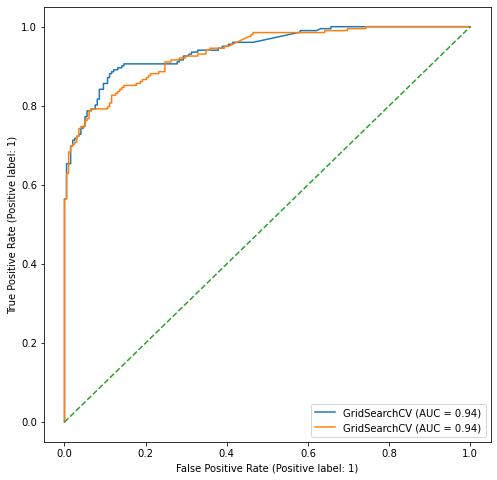

In [163]:
plot_compare_roc_auc(gs_cvec_rf, gs_tvec_rf, X_test, y_test)

**Key Observations**
- ROC AUC score is better compared to bagging, despite similar test accuracy rates.
- Sensitivity is lousier compared to bagging, might incur more false negatives compared to bagging.

<hr style="border:2px solid gray"> </hr>

<a id='et'></a>
## ExtraTrees Classifier

### CountVectorizer with ExtraTreesClassifier

In [164]:
pipe_cvec_et = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('et', ExtraTreesClassifier(random_state=42)),
])

In [165]:
pipe_cvec_et_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,1)],
    'et__n_estimators':[400],
    'et__max_depth':  [None],
}

In [166]:
gs_cvec_et = GridSearchCV(pipe_cvec_et, param_grid=pipe_cvec_et_params,cv=5,verbose=1)

In [167]:
%%time
gs_cvec_et.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 11.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [168]:
gs_cvec_et.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'et__max_depth': None,
 'et__n_estimators': 400}

In [169]:
print(f'Best score for training: {gs_cvec_et.best_score_}')
print(f'Accuracy on train set: {gs_cvec_et.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_cvec_et.score(X_test, y_test)}')

Best score for training: 0.8931250000000001
Accuracy on train set: 1.0
Accuracy on test set: 0.85


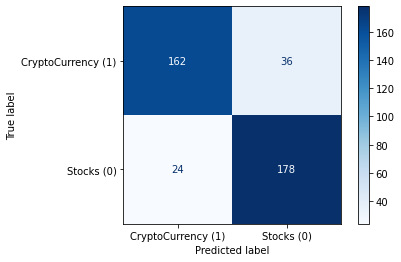

In [170]:
mod_metrics = metrics_and_plot_cm(gs_cvec_et,X_test, y_test)

In [171]:
results_df = append_results(results_df,
                            gs_cvec_et.score(X_train,y_train),
                            mod_metrics,
                            'ExtraTrees',
                            'CountVectorizer',
                            get_misclassed_data(X_test, gs_cvec_et.predict(X_test), y_test)
                           )

In [172]:
top_cvec_et_features = pd.DataFrame([gs_cvec_et.best_estimator_['et'].feature_importances_], 
                                   columns=gs_cvec_et.best_estimator_['cvec'].get_feature_names())
top_cvec_et_features = top_cvec_et_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

In [173]:
top_cvec_et_features.sort_values(ascending=False, by='coefficient').head(10)

,word,coefficient
140,btc,0.019795
393,eth,0.016827
1319,wallet,0.014091
482,fud,0.012492
935,projects,0.010765
405,exchanges,0.009349
904,posts,0.007050
1320,wallets,0.006512
125,binance,0.006400
19,ada,0.006071


### TfidfVectorizer with ExtraTreesClassifier

In [174]:
pipe_tvec_et = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('et', ExtraTreesClassifier(random_state=42)),
])

In [175]:
pipe_tvec_et_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,2)],
    'et__n_estimators':[500],
    'et__max_depth':  [None],
}

In [176]:
gs_tvec_et = GridSearchCV(pipe_tvec_et, param_grid=pipe_tvec_et_params,cv=5,verbose=1)

In [177]:
%%time
gs_tvec_et.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 14.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['without',
                                                                    'yourself',
                                                                    'at',
                                                                    'whoever',
                                                                    'all',
                                                                    'mostly',
                                                                    'had',
                                                                    'seem',
                                                                    'now',
                                                                    'these',
                                                                    'across',
                                                                    'between',
        

In [178]:
gs_tvec_et.best_params_

{'et__max_depth': None,
 'et__n_estimators': 500,
 'tvec__max_df': 0.95,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [179]:
print(f'Best score for training: {gs_tvec_et.best_score_}')
print(f'Accuracy on train set: {gs_tvec_et.score(X_train,y_train)}')
print(f'Accuracy on test set: {gs_tvec_et.score(X_test, y_test)}')

Best score for training: 0.905
Accuracy on train set: 1.0
Accuracy on test set: 0.865


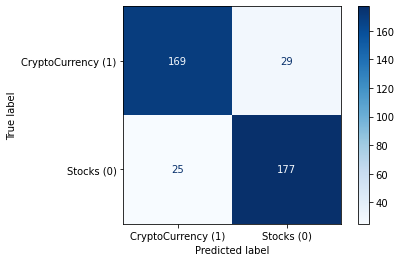

In [180]:
mod_metrics = metrics_and_plot_cm(gs_tvec_et,X_test, y_test)

In [181]:
results_df = append_results(results_df,
                            gs_tvec_et.score(X_train,y_train),
                            mod_metrics,
                            'ExtraTrees',
                            'TfidfVectorizer',
                            get_misclassed_data(X_test, gs_tvec_et.predict(X_test), y_test)
                           )

In [182]:
top_tvec_et_features = pd.DataFrame([gs_tvec_et.best_estimator_['et'].feature_importances_], 
                                   columns=gs_tvec_et.best_estimator_['tvec'].get_feature_names())
top_tvec_et_features = top_tvec_et_features.T.reset_index().rename(columns={
    'index':'word',
    0:'coefficient'
})

In [183]:
top_tvec_et_features.sort_values(ascending=False, by='coefficient').head(10)

,word,coefficient
142,btc,0.023155
1347,wallet,0.019699
402,eth,0.015093
496,fud,0.010632
954,projects,0.009511
416,exchanges,0.009356
1117,share,0.008492
586,hodl,0.008070
1283,transactions,0.007203
824,nft,0.006973


### Comparing both ExtraTrees Models

In [184]:
results_df.loc[results_df['model'] == 'ExtraTrees',['vectorizer','train_accuracy','test_accuracy','misclassification','sensitivity','specificity','precision','f1_score','roc_auc']]

,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
12,CountVectorizer,1.0,0.850,0.150,0.881188,0.818182,0.831776,0.855769,0.921755
13,TfidfVectorizer,1.0,0.865,0.135,0.876238,0.853535,0.859223,0.867647,0.932493


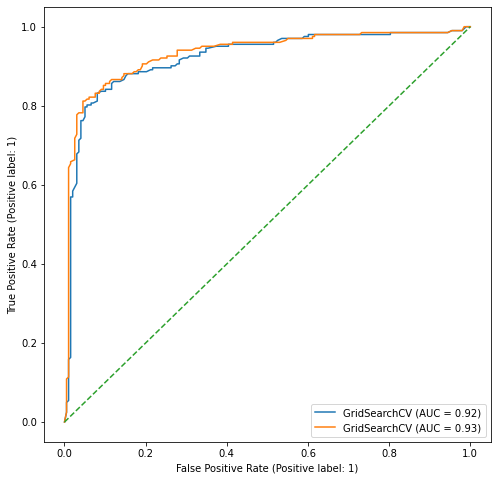

In [185]:
plot_compare_roc_auc(gs_cvec_et, gs_tvec_et, X_test, y_test)

**Key Observations**
- Has good sensitivity and specificity
- ROC AUC not better than Random Forest

<hr style="border:2px solid gray"> </hr>

# Evaluation

## Evaluation of Chosen Model vs Random Forest

We can see the results of our models' performance on the test data below. For the purposes of this project, I will focus on comparing between our top model of choice and Random Forest Classifier, based on the ROC AUC score, followed by their Sensitivity and their Specificity. This is because we'd want our models to have less false positive and false negatives, so that we do not wrongly provide wrong news and trends to our client.

Below is the summary of the results for our models.

In [186]:
results_df

,model,vectorizer,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc,chart,misclassed_data
0,Logistic Regression,CountVectorizer,0.995625,0.8500,0.1500,0.806931,0.893939,0.885870,0.844560,0.934343,<sklearn.metrics._plot.confusion_matrix.Confus...,[well the situation is as follows ended up wit...
1,Logistic Regression,TfidfVectorizer,0.969375,0.8825,0.1175,0.866337,0.898990,0.897436,0.881612,0.953570,<sklearn.metrics._plot.confusion_matrix.Confus...,[i'm not scared of you people constantly threa...
2,K-Nearest Neighbors,CountVectorizer,0.582500,0.5625,0.4375,0.133663,1.000000,1.000000,0.235808,0.726273,<sklearn.metrics._plot.confusion_matrix.Confus...,[yes that's right blew my load too early once ...
3,K-Nearest Neighbors,TfidfVectorizer,0.876875,0.8350,0.1650,0.806931,0.863636,0.857895,0.831633,0.905366,<sklearn.metrics._plot.confusion_matrix.Confus...,[less than two months after starting the deck ...
4,Naive Bayes,CountVectorizer,0.920000,0.8700,0.1300,0.925743,0.813131,0.834821,0.877934,0.957996,<sklearn.metrics._plot.confusion_matrix.Confus...,[earlier today someone new to stock market pos...
5,Naive Bayes,TfidfVectorizer,0.938125,0.8900,0.1100,0.925743,0.853535,0.865741,0.894737,0.960671,<sklearn.metrics._plot.confusion_matrix.Confus...,[earlier today someone new to stock market pos...
6,Decision Tree,CountVectorizer,0.844375,0.7775,0.2225,0.777228,0.777778,0.781095,0.779156,0.860274,<sklearn.metrics._plot.confusion_matrix.Confus...,[let's say the float is somewhere around milli...
7,Decision Tree,TfidfVectorizer,0.851875,0.8075,0.1925,0.722772,0.893939,0.874251,0.791328,0.843784,<sklearn.metrics._plot.confusion_matrix.Confus...,[where does the cpi get its shelter component ...
8,Bagging,CountVectorizer,1.000000,0.8400,0.1600,0.821782,0.858586,0.855670,0.838384,0.916642,<sklearn.metrics._plot.confusion_matrix.Confus...,[i'm not scared of you people constantly threa...
9,Bagging,TfidfVectorizer,1.000000,0.8600,0.1400,0.826733,0.893939,0.888298,0.856410,0.917667,<sklearn.metrics._plot.confusion_matrix.Confus...,[if you have decided buy crypto then you have ...


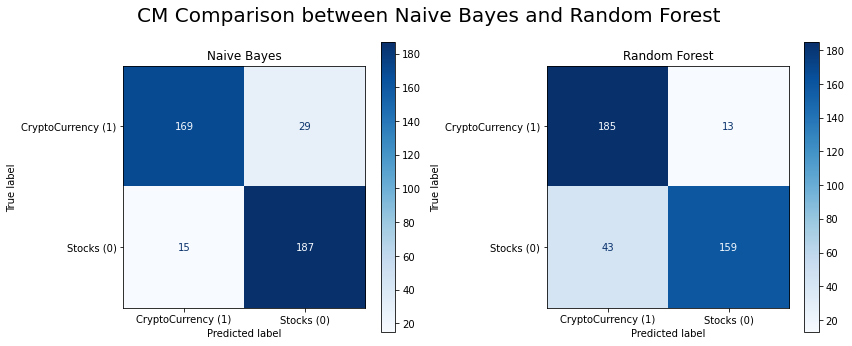

In [196]:
plot_compare_diff_cm(
    results_df.loc[(results_df['model'] == 'Naive Bayes') & (results_df['vectorizer'] == 'TfidfVectorizer'),'chart'].values[0],
    results_df.loc[(results_df['model'] == 'Random Forest') & (results_df['vectorizer'] == 'TfidfVectorizer'),'chart'].values[0],
    'Naive Bayes',
    'Random Forest',
    'CM Comparison between Naive Bayes and Random Forest'
)

Any errorneous classifications would most likely result the wrong recommendation of investment to a client, regardless for CryptoCurrency or stocks purposes. We can see that our Random Forest model results in a high false positive rate, but has a lower false negative rate as compared to our Naive Bayes model.

Although the Naive Bayes model may have good scores, our Random Forest model shows a high amount of specificity, which shows that it classified most of the subreddits related to stocks pretty well. Our Random Forest model also has a high ROC AUC score, which indicates it is able to distinguish between CryptoCurrency and stocks.

## Misclassification Analysis

In [1]:
common_misclassed = set(results_df['misclassed_data'][0])
for idx in range(len(results_df['misclassed_data']) - 1):
    compare_set = results_df['misclassed_data'][idx+1]
    for item in compare_set:
        common_misclassed.add(item)
    
list(common_misclassed)[0]  ## Showing 1st sample of misclassified data from all models

NameError: name 'results_df' is not defined

Collecting the commonly misclassified subreddits, we see that some posts are filled with repeated texts to meet the word count limit in a post. We also see a post with text written as `geslner as voldemort`, which is likely representative of Gary Gensler, the Chairman of the U.S Securities and Exchange Commission and his comments on the recent stock shorting of Gamestop by retail investors. However, it is not indicative of which classification this subreddit should belong to. This suggests that some subreddit posts are fueled by events, which don't usually describe much with relation to the classification.

Repeated texts are also found in our subreddits, such as the repeated text of `buy the dip`. This would affect our vectorizers in counting the occurences of words, and in CountVectorizers, boost the occurence score of the word, making it a highly scored feature.

There are also subreddits describing about their mining rig builds, which are more of computer hardware specifications in nature, but no keywords related to cryptocurrency. It is possibly conclusive that the word `mining` can refer to various meanings, notably one subreddit related to the mining industry, particularly in copper, being heavily impacted due to the pandemic, which would be stock-related instead.

Some subreddits also have no keywords or indication with relation to our subreddits. For example, the quoted subreddit below carry hints of frustration for the imposing of tax-reporting requirements for cryptocurrency brokers at the upcoming infrastructure bill to be passed in the U.S. <sup>5,6</sup>

>Here is a quick article on democrats that are opposed to the infrastructure bill, pay attention. If these are you representatives call them, let them know they WILL receive your votes to keep them in office. And those for the bill, that they will NOT be staying in office. It's time to take the power back guys: 
"Republicans have publicly indicated they'll back the bipartisan bill:Â Reps. Brian Fitzpatrick (Pa.), the co-chair of the bipartisan Problem Solvers Caucus, as well as Adam Kinzinger (Ill.), Tom Reed (N.Y.) andÂ Fred UptonÂ (Mich.)" <sup>7</sup>


There are also investing jargons that are frequently and interchangeable used between both subreddits. We see occurences of `ath` (all time highest), `dyor` (do your own research). Some subreddits in stocks that mention about cryptocurrency as a form of investment, which might be confusing in terms of classification for our models. We also see common phrases that are more used for positivity towards a particular stock or cryptocurrency, such as `this is the way`, which usually doesn't contribute much to our classification needs and introduces noise instead.

## Recommendation

On reviewing of the the results mentioned above, the recommended model to use would be the TfidfVectorizer Naive Bayes model. The scores of its sensitivity, specificity and misclassification rate would minimise future similar datasets for classification, as compared to the Random Forest, which might incur more false positives in the long run.

# Conclusion and Learnings

Setting random seeds to provide an apple-to-apple comparison between models can affect model performance and metric scores. Prior to setting random seeds for comparison, I noted ExtraTrees performing excessively well. However, the accuracy dropped by 10% on adding `random_state=42`. This would signify that the model is not robust and may not generalise with new unseen data in the future.

Visibly, it is also noticeable that majority of the top features are related to cryptocurrency, instead of having a balance of features from both subreddits. While our baseline score is based on the equal rows of data from each subreddit, the textual content in each subreddit post has a heavier weightage in terms of providing better feature scores for a more accurate classification model. Although having more data would suggest that the model will improve, having more data also introduces additional noise in the model.

This would also have an added effect on the choice of vectorizers, since CountVectorizer scores features with the highest occurences. This would skew the scores of the features over time, if the text within the subreddits are not of good feature quality. 

In terms of classification, scikit-learn also recommends Naive Bayes<sup>8</sup> for classification of text data with less than 100,000 samples.

**Citation** <br>
<sup>1</sup>https://www.bbc.com/news/business-58729791<br>
<sup>2</sup>https://www.cnbc.com/2021/09/20/cramer-says-take-crypto-profits-cites-evergrande-related-tether-risks.html<br>
<sup>3</sup>https://www.bbc.com/news/technology-58678907<br>
<sup>4</sup>https://www.reuters.com/technology/cryptocurrency-exchanges-rush-cut-ties-with-chinese-users-after-fresh-crackdown-2021-09-27/<br>
<sup>5</sup>https://apnews.com/article/technology-joe-biden-business-bills-cryptocurrency-92628a41124230448f65fdeb89ffad7d <br>
<sup>6</sup>https://www.cnbc.com/2021/08/11/crypto-lawmakers-fought-over-the-infrastructure-bill-heres-whats-next.html <br>
<sup>7</sup>https://thehill.com/homenews/house/573409-whip-list-how-house-democrats-say-theyll-vote-on-infrastructure-bill<br>
<sup>8</sup>https://scikit-learn.org/stable/tutorial/machine_learning_map/<br>